# Workout classfication

## Importamos las librerías

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import split_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

## Veamos unos ejemplos de nuestras imágenes

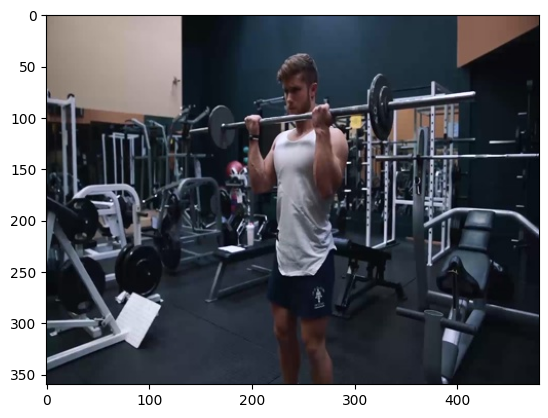

In [2]:
plt.imshow(plt.imread("../data/barbell biceps curl/barbell biceps curl_100001.jpg"))

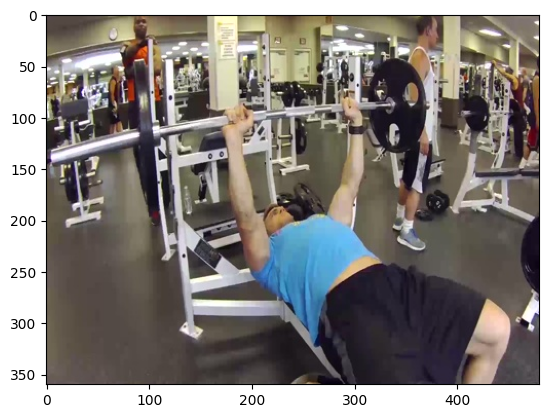

In [3]:
plt.imshow(plt.imread("../data/bench press/bench press_100001.jpg"))

## Preprocesado de los datos

In [4]:
DATA_DIR = "../data/"
CLASSES = os.listdir(DATA_DIR)
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

In [5]:
images =[]
labels =[]
for class_ in CLASSES:
    for image in os.listdir(os.path.join(DATA_DIR, class_)):
        image = plt.imread(os.path.join(DATA_DIR, class_, image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH)))
        labels.append(class_)
    print(class_)

barbell biceps curl
bench press
chest fly machine
deadlift
decline bench press
hammer curl
hip thrust
incline bench press
lat pulldown
lateral raises
leg extension
leg raises
plank
pull up
push up
romanian deadlift
russian twist
shoulder press
squat
t bar row
tricep dips
tricep pushdown


In [ ]:
np.array(images).shape

(13853, 128, 128, 3)

In [ ]:
np.unique(labels, return_counts=True)[1]

array([705, 625, 527, 530, 514, 546, 557, 729, 646, 843, 586, 514, 993,
       615, 601, 555, 522, 512, 742, 668, 698, 625], dtype=int64)

## Análisis

<BarContainer object of 22 artists>

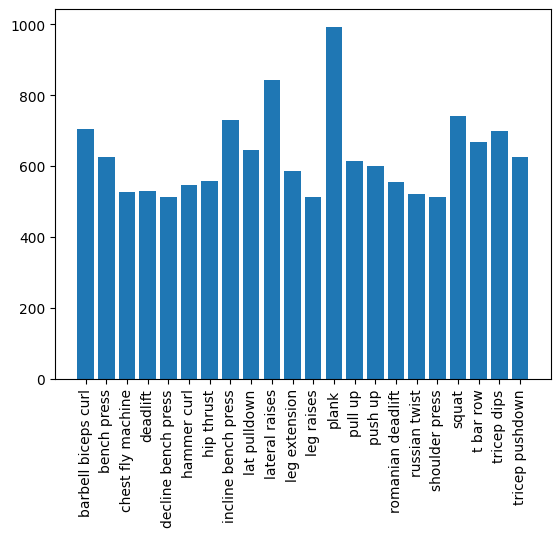

In [25]:
plt.xticks(rotation=90)
plt.bar(np.unique(labels, return_counts=True)[0], height = np.unique(labels, return_counts=True)[1])

#### Vemos que el número de valores para cada ejercio no difiere mucho del resto por lo general. Vemos que "plank" es el ejercicio con mayores registros.

## Preparación de los datos

In [6]:
le = LabelEncoder()
le.fit(labels)
le.classes_

array(['barbell biceps curl', 'bench press', 'chest fly machine',
       'deadlift', 'decline bench press', 'hammer curl', 'hip thrust',
       'incline bench press', 'lat pulldown', 'lateral raises',
       'leg extension', 'leg raises', 'plank', 'pull up', 'push up',
       'romanian deadlift', 'russian twist', 'shoulder press', 'squat',
       't bar row', 'tricep dips', 'tricep pushdown'], dtype='<U19')

In [7]:
labels = le.transform(labels)

In [8]:
labels

array([ 0,  0,  0, ..., 21, 21, 21])

In [206]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, shuffle = True, random_state = 2, test_size = 0.2)

In [9]:
print(len(xtrain))
print(len(xtest))
print(len(ytrain))
print(len(ytest))

11082
2771
11082
2771


In [208]:
xtrain = np.array(xtrain)
xtest = np.array(xtest)

In [209]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range= 0.1,
    height_shift_range = 0.1, 
    validation_split = 0.1
)

In [210]:
train_generator = datagen.flow(xtrain, ytrain, subset = "training", shuffle=True)

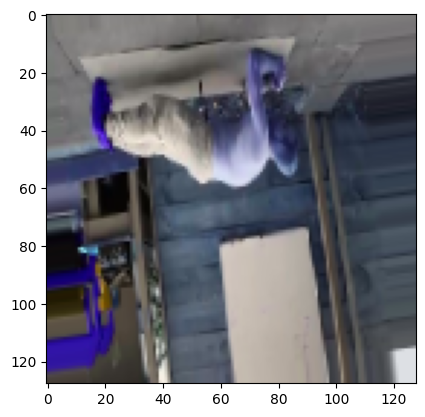

In [211]:
plt.imshow(train_generator[0][0][0])

## Creación del modelo

In [212]:
len(np.unique(labels))

22

In [213]:
layers = [keras.layers.Conv2D(64,(3,3), activation = "relu", input_shape = (128,128,3)), 
          keras.layers.MaxPool2D((2,2)),
          keras.layers.Conv2D(128,(3,3), activation = "relu"), 
          keras.layers.MaxPool2D((2,2)),
          keras.layers.Conv2D(256,(3,3), activation = "relu"), 
          keras.layers.MaxPool2D((2,2)),
          keras.layers.Flatten(), 
          keras.layers.Dense(128, activation = "relu"), 
          keras.layers.Dense(22, activation = "sigmoid")]

In [214]:
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [215]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 256)     

In [216]:
earlystop = EarlyStopping(patience=5)
mcheckpoint = ModelCheckpoint("callback_model.h5")

In [218]:
history = model.fit(train_generator,
         epochs = 10,
         batch_size = 32,
         callbacks = [earlystop, mcheckpoint])

Epoch 1/10
312/312 [==============================] - 550s 2s/step - loss: 2.7518 - accuracy: 0.1896
Epoch 2/10
312/312 [==============================] - 543s 2s/step - loss: 1.7929 - accuracy: 0.4765
Epoch 3/10
312/312 [==============================] - 542s 2s/step - loss: 1.2299 - accuracy: 0.6423
Epoch 4/10
312/312 [==============================] - 559s 2s/step - loss: 0.9070 - accuracy: 0.7468
Epoch 5/10
312/312 [==============================] - 618s 2s/step - loss: 0.7342 - accuracy: 0.7966
Epoch 6/10
312/312 [==============================] - 606s 2s/step - loss: 0.5925 - accuracy: 0.8388
Epoch 7/10
312/312 [==============================] - 611s 2s/step - loss: 0.5018 - accuracy: 0.8682
Epoch 8/10
312/312 [==============================] - 610s 2s/step - loss: 0.4374 - accuracy: 0.8817
Epoch 9/10
312/312 [==============================] - 613s 2s/step - loss: 0.3825 - accuracy: 0.8940
Epoch 10/10
312/312 [==============================] - 627s 2s/step - loss: 0.3520 - accura

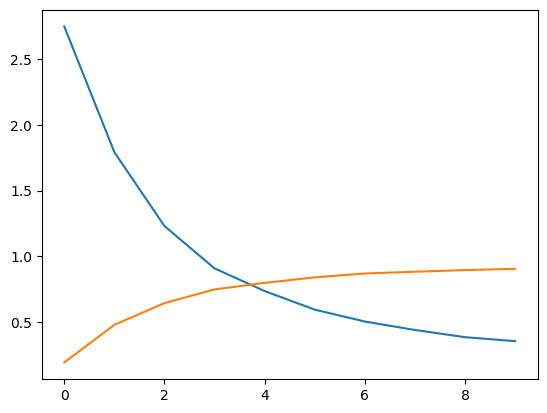

In [220]:
plt.plot(pd.DataFrame(history.history))

#### Vemos como la función de coste va reduciendose mientras que la métrica accuracy va aumentando, esto muestra una buena evolución del entrenamiento.

## Evaluación del modelo

In [248]:
predict = model.predict(xtest)

87/87 [==============================] - 41s 474ms/step


In [249]:
predictions = np.argmax(predict, axis=1)

In [240]:
print("Accuracy: ", metrics.accuracy_score(ytest, predictions))
print("Precission: ", metrics.precision_score(ytest, predictions, average = "micro"))
print("Recall: ", metrics.recall_score(ytest, predictions, average = "micro"))

Accuracy:  0.09527246481414652
Precission:  0.09527246481414652
Recall:  0.09527246481414652


#### Vemos que nuestro modelo aprendió bien en el entrenamiento pero para datos nuevos no predice bien. Puede ser un problema de overfitting, veamos que tal a modificar la red neuronal.

## Segunda red neuronal

## Le añadiremos la capa "dropout" y datos de validación.

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, shuffle = True, random_state = 2, test_size = 0.2)

In [8]:
xtrain = np.array(xtrain)
xtest = np.array(xtest)

In [276]:
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, shuffle = True, random_state = 2, test_size = 0.1)

In [304]:
print(len(xtrain))
print(len(xval))
print(len(xtest))
print(len(ytrain))
print(len(yval))
print(len(ytest))

9973
1109
2771
9973
1109
2771


In [277]:
train_generator = datagen.flow(xtrain, ytrain, subset = "training", shuffle=True)
val_generator = datagen.flow(xval, yval, subset = "training", shuffle=True)

In [278]:
layers = [keras.layers.Conv2D(64,(3,3), activation = "relu", input_shape = (128,128,3)), 
          keras.layers.MaxPool2D((2,2)),
          keras.layers.Conv2D(128,(3,3), activation = "relu"), 
          keras.layers.MaxPool2D((2,2)),
          keras.layers.Conv2D(256,(3,3), activation = "relu"), 
          keras.layers.MaxPool2D((2,2)),
          keras.layers.Dropout(0.05),
          keras.layers.Flatten(), 
          keras.layers.Dense(128, activation = "relu"), 
          keras.layers.Dense(22, activation = "sigmoid")]

In [279]:
model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [280]:
history = model.fit(train_generator,
         epochs = 10,
         batch_size = 32,
         callbacks = [earlystop, mcheckpoint], 
         validation_data = val_generator)

Epoch 1/10
281/281 [==============================] - 546s 2s/step - loss: 2.6448 - accuracy: 0.2296 - val_loss: 1.9560 - val_accuracy: 0.4414
Epoch 2/10
281/281 [==============================] - 518s 2s/step - loss: 1.5724 - accuracy: 0.5451 - val_loss: 1.2763 - val_accuracy: 0.6216
Epoch 3/10
281/281 [==============================] - 537s 2s/step - loss: 1.0592 - accuracy: 0.7047 - val_loss: 0.8738 - val_accuracy: 0.7508
Epoch 4/10
281/281 [==============================] - 555s 2s/step - loss: 0.7717 - accuracy: 0.7854 - val_loss: 0.7288 - val_accuracy: 0.8248
Epoch 5/10
281/281 [==============================] - 556s 2s/step - loss: 0.6181 - accuracy: 0.8275 - val_loss: 0.6398 - val_accuracy: 0.8298
Epoch 6/10
281/281 [==============================] - 556s 2s/step - loss: 0.4933 - accuracy: 0.8673 - val_loss: 0.6304 - val_accuracy: 0.8649
Epoch 7/10
281/281 [==============================] - 567s 2s/step - loss: 0.4367 - accuracy: 0.8810 - val_loss: 0.4837 - val_accuracy: 0.8749

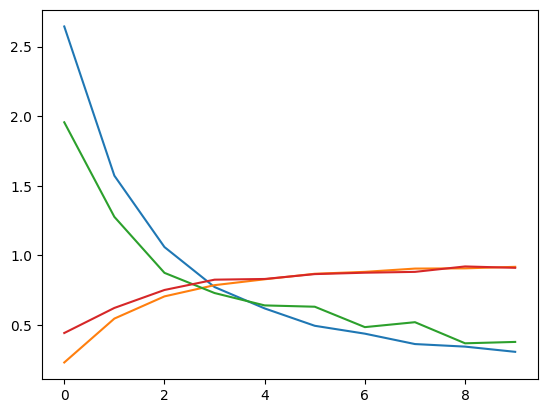

In [290]:
plt.plot(pd.DataFrame(history.history))

#### Vemos como, en el anterior caso las funciones de perdida tanto de train como de validation van disminuyendo mientras aumenta el accuracy.

In [295]:
predict = model.predict(xtest)

87/87 [==============================] - 38s 438ms/step


In [302]:
predictions = np.argmax(predict, axis=1)

In [303]:
print("Accuracy: ", metrics.accuracy_score(ytest, predictions))
print("Precission: ", metrics.precision_score(ytest, predictions, average = "micro"))
print("Recall: ", metrics.recall_score(ytest, predictions, average = "micro"))

Accuracy:  0.14290869722121977
Precission:  0.14290869722121977
Recall:  0.14290869722121977


#### Como no nos han funcionado las redes neuronales vamos a probar un random forest classifier.

## Tercer modelo

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, shuffle = True, random_state = 2, test_size = 0.2)

In [ ]:
xtrain = np.array(xtrain)
xtest = np.array(xtest)

In [ ]:
print(xtrain.shape)
print(xtest.shape)

(11082, 128, 128, 3)
(2771, 128, 128, 3)


In [ ]:
xtrain = xtrain.reshape(11082, 49152)
xtest = xtest.reshape(2771, 49152)

In [ ]:
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)

RandomForestClassifier()

In [ ]:
predictions = rf.predict(xtest)

In [15]:
predictions_rc = rf.predict_proba(xtest)

In [16]:
print("Accuracy: ", metrics.accuracy_score(ytest, predictions))
print("Precission: ", metrics.precision_score(ytest, predictions, average = "micro"))
print("Recall: ", metrics.recall_score(ytest, predictions, average = "micro"))
print("ROC Curve:", metrics.roc_auc_score(ytest, predictions_rc, multi_class = "ovr"))

Accuracy:  0.9631901840490797
Precission:  0.9631901840490797
Recall:  0.9631901840490797
ROC Curve: 0.9966305363150595


#### Ahora parece que nuestro modelo predice mucho mejor que antes

## Guardamos el modelo

In [20]:
with open('../models/model.h5', 'wb') as handle:
    pickle.dump(rf, handle, protocol=pickle.HIGHEST_PROTOCOL)